# Contents

### 1 Import Packages

### 2 Load Data

#### 2.1 Checking for NULLs

#### 2.2 Handling NULLs

#### 2.3 Handling dates

### 3 Handling Data

#### 3.1 Set date as index

#### 3.2 Train/Test Split

#### 3.3 Resample Data

### 4 Checking Data

#### 4.1 Visualizing the time series

#### 4.2 Stationarity Test

#### 4.3 Differencing

#### 4.4 Granger Causality Test

### 5 VAR - Vector Auto Regression

#### 5.1 Forecasting on Test data index

#### 5.2 Invert Differencing - Not required because there was no differencing done

#### 5.3 Plot the forecast and actual values

#### 5.4 Evaluate the forecasts

### 1 Import Packages

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

%config Completer.use_jedi = False

### 2 Load Data

In [2]:
perthTemp = pd.read_csv("data/PerthTemperatures.csv")

#### 2.1 Checking for NULLs

In [3]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
Quality                           31
dtype: int64

In [4]:
perthTemp.drop(columns=['Quality'], inplace=True)

#### 2.2 Handling NULLs

In [5]:
perthTemp.fillna(method='bfill', inplace = True)

In [6]:
perthTemp.isnull().sum()

Year                              1
Month                             1
Day                               1
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    1
Rainfall amount (millimetres)     0
dtype: int64

In [7]:
perthTemp.drop(perthTemp.tail(1).index, inplace=True)

In [8]:
perthTemp.isnull().sum()

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
dtype: int64

#### 2.3 Handling dates

In [9]:
perthTemp

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944.0,6.0,3.0,11.0,22.3,0.0
1,1944.0,6.0,4.0,12.2,23.4,0.0
2,1944.0,6.0,5.0,12.0,20.3,2.0
3,1944.0,6.0,6.0,7.4,18.7,3.3
4,1944.0,6.0,7.0,5.9,21.3,0.3
...,...,...,...,...,...,...
27641,2020.0,2.0,6.0,21.0,32.6,0.0
27642,2020.0,2.0,7.0,20.7,30.6,0.0
27643,2020.0,2.0,8.0,19.6,28.2,0.0
27644,2020.0,2.0,9.0,14.1,29.8,0.0


In [10]:
perthTemp['Date'] = pd.to_datetime(perthTemp[['Year', 'Month', 'Day']])

In [11]:
perthTemp.drop(columns=['Year', 'Month', 'Day'], inplace = True)

In [12]:
perthTemp.dtypes

Minimum temperature (Degree C)           float64
Maximum temperature (Degree C)           float64
Rainfall amount (millimetres)            float64
Date                              datetime64[ns]
dtype: object

### 3 Handling Data

#### 3.1 Set date as index

In [13]:
# Set the date as index 
perthTemp_2 = perthTemp.set_index('Date')

In [14]:
perthTemp_2

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
1944-06-03,11.0,22.3,0.0
1944-06-04,12.2,23.4,0.0
1944-06-05,12.0,20.3,2.0
1944-06-06,7.4,18.7,3.3
1944-06-07,5.9,21.3,0.3
...,...,...,...
2020-02-06,21.0,32.6,0.0
2020-02-07,20.7,30.6,0.0
2020-02-08,19.6,28.2,0.0


#### 3.2 Train/Test Split

In [15]:
perthTemp_Train = perthTemp_2[:'2010-12-31']

perthTemp_Test = perthTemp_2['2011-01-01':]

#### 3.3 Resample Data

In [16]:
perthTemp_Train_MS = perthTemp_Train.resample('MS').mean()
perthTemp_Test_MS = perthTemp_Test.resample('MS').mean()

### 4 Checking Data

In [17]:
perthTemp_Train_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp',
                                'Rainfall amount (millimetres)':'rainfall'}, inplace=True)

perthTemp_Test_MS.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp',
                                'Rainfall amount (millimetres)':'rainfall'}, inplace=True)

perthTemp_Train_MS

,mintemp,maxtemp,rainfall
Date,,,
1944-06-01,8.107143,20.421429,2.750000
1944-07-01,7.700000,18.254839,5.722581
1944-08-01,7.093548,19.509677,3.493548
1944-09-01,7.870000,20.316667,1.770000
1944-10-01,10.487097,24.648387,0.545161
...,...,...,...
2010-08-01,5.980645,19.454839,1.935484
2010-09-01,8.016667,22.140000,0.926667
2010-10-01,9.703226,25.129032,0.812903


#### 4.1 Visualizing the time series

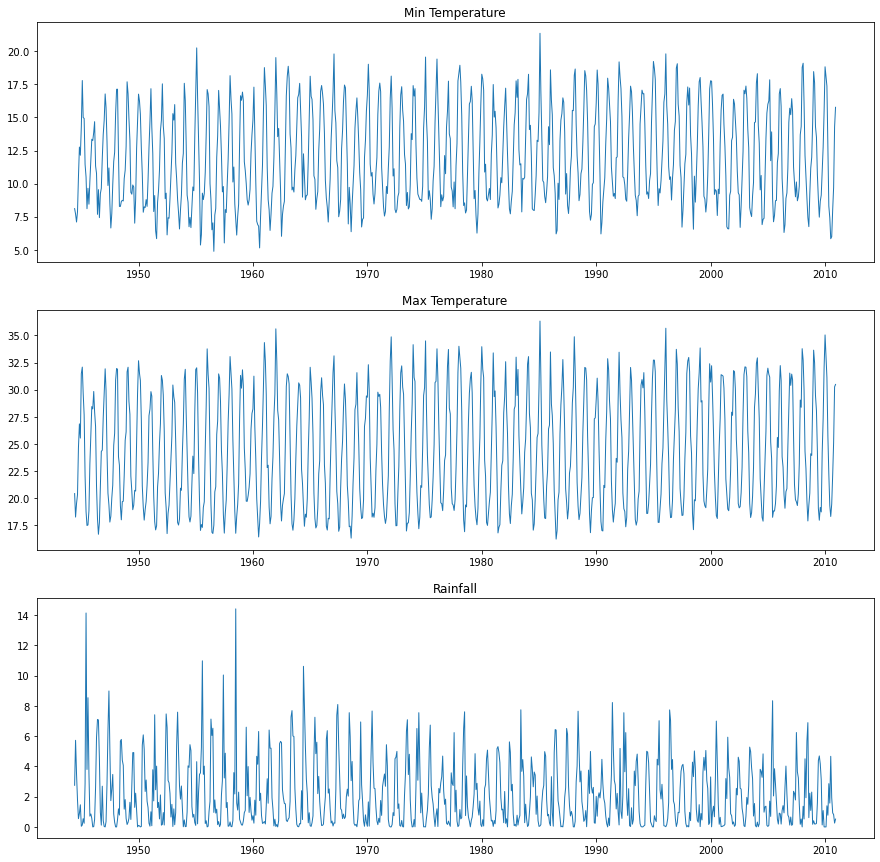

In [18]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.title('Min Temperature')
plt.plot(perthTemp_Train_MS[['mintemp']], linewidth = 1)

plt.subplot(3,1,2)
plt.title('Max Temperature')
plt.plot(perthTemp_Train_MS[['maxtemp']], linewidth = 1)

plt.subplot(3,1,3)
plt.title('Rainfall')
plt.plot(perthTemp_Train_MS[['rainfall']], linewidth = 1)

plt.show()

#### 4.2 Stationarity Test

In [19]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [20]:
print('Temperature\n')
adf_test(perthTemp_Train_MS[['mintemp']])
print('\nWind Speed\n')
adf_test(perthTemp_Train_MS[['maxtemp']])
print('\nHumidity\n')
adf_test(perthTemp_Train_MS[['rainfall']])

Temperature

Test Statistic           -3.975318
p-value                   0.001545
# Lags                   21.000000
# Observations          777.000000
Critical Value (1%)      -3.438794
Critical Value (5%)      -2.865267
Critical Value (10%)     -2.568755
dtype: float64
 Series is Stationary

Wind Speed

Test Statistic           -3.983690
p-value                   0.001498
# Lags                   21.000000
# Observations          777.000000
Critical Value (1%)      -3.438794
Critical Value (5%)      -2.865267
Critical Value (10%)     -2.568755
dtype: float64
 Series is Stationary

Humidity

Test Statistic           -5.204728
p-value                   0.000009
# Lags                   12.000000
# Observations          786.000000
Critical Value (1%)      -3.438697
Critical Value (5%)      -2.865224
Critical Value (10%)     -2.568732
dtype: float64
 Series is Stationary


#### 4.3 Differencing (Not necessary because the time series is stationary)

In [21]:
# differencedTrainMS = dfTrainMS.diff()

In [22]:
# plt.figure(figsize=(15,15))

# plt.subplot(3,1,1)
# plt.title('Temperature Differenced')
# plt.plot(differencedTrainMS[['meantemp']], linewidth = 1)

# plt.subplot(3,1,2)
# plt.title('Wind Differenced')
# plt.plot(differencedTrainMS[['wind_speed']], linewidth = 1)

# plt.subplot(3,1,3)
# plt.title('Humidity Differenced')
# plt.plot(differencedTrainMS[['humidity']], linewidth = 1)

# plt.show()

#### Check NULLS in the differenced time series

In [23]:
# differencedTrainMS = differencedTrainMS.dropna(how='all')

In [24]:
# differencedTrainMS = differencedTrainMS.drop(columns=['meanpressure'])

In [25]:
# differencedTrainMS.isnull().sum()

#### 4.4 Granger Causality - Testing if the variables influence each other

In [26]:
maxlag=12
test = 'ssr-chi2test'

In [27]:
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:
            
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
            
    return dataset

In [28]:
grangers_causality_matrix(perthTemp_Train_MS, variables = perthTemp_Train_MS.columns, verbose = True)

Y = mintemp, X = mintemp, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = maxtemp, X = mintemp, P Values = [0.0, 0.0, 0.0, 0.0004, 0.0001, 0.0001, 0.0001, 0.0002, 0.0005, 0.0022, 0.0014, 0.0007]
Y = rainfall, X = mintemp, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = mintemp, X = maxtemp, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = maxtemp, X = maxtemp, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = rainfall, X = maxtemp, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = mintemp, X = rainfall, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = maxtemp, X = rainfall, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = rainfall, X = rainfall, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,mintemp_x,maxtemp_x,rainfall_x
mintemp_y,1.0,0.0,0.0
maxtemp_y,0.0,1.0,0.0
rainfall_y,0.0,0.0,1.0


### 5 VAR - Vector Auto Regression

In [29]:
testModel = None
testModel = VAR(perthTemp_Train_MS)

In [30]:
results = testModel.fit(ic='aic')

In [31]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, May, 2021
Time:                     13:20:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.38855
Nobs:                     786.000    HQIC:                  0.949985
Log likelihood:          -3491.54    FPE:                    1.96660
AIC:                     0.676042    Det(Omega_mle):         1.69451
--------------------------------------------------------------------
Results for equation mintemp
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                6.615963         2.047162            3.232           0.001
L1.mintemp           0.268884         0.054706            4.915           0.000
L1.maxtemp           0.063765         0.050593            1.26

#### 5.1 Forecasting on Test data index

In [32]:
prediction = results.forecast(results.endog, steps = len(perthTemp_Test_MS))

In [33]:
predictionDF = pd.DataFrame(prediction, columns=['mintemp', 'maxtemp', 'rainfall'], index=perthTemp_Test_MS.index)

#### 5.2 Invert Differencing - Not required because there was no differencing done

In [34]:
# predDF = pd.DataFrame(columns=['meantemp', 'humidity', 'wind_speed'], index=dfTestMS.index)

In [35]:
# predDF['meantemp'] = np.r_[dfTrainMS[-1:]['meantemp'][0], diffPredDF['meantemp']].cumsum()[1:]
# predDF['humidity'] = np.r_[dfTrainMS[-1:]['humidity'][0], diffPredDF['humidity']].cumsum()[1:]
# predDF['wind_speed'] = np.r_[dfTrainMS[-1:]['wind_speed'][0], diffPredDF['wind_speed']].cumsum()[1:]

#### 5.3 Plot the forecast and actual values

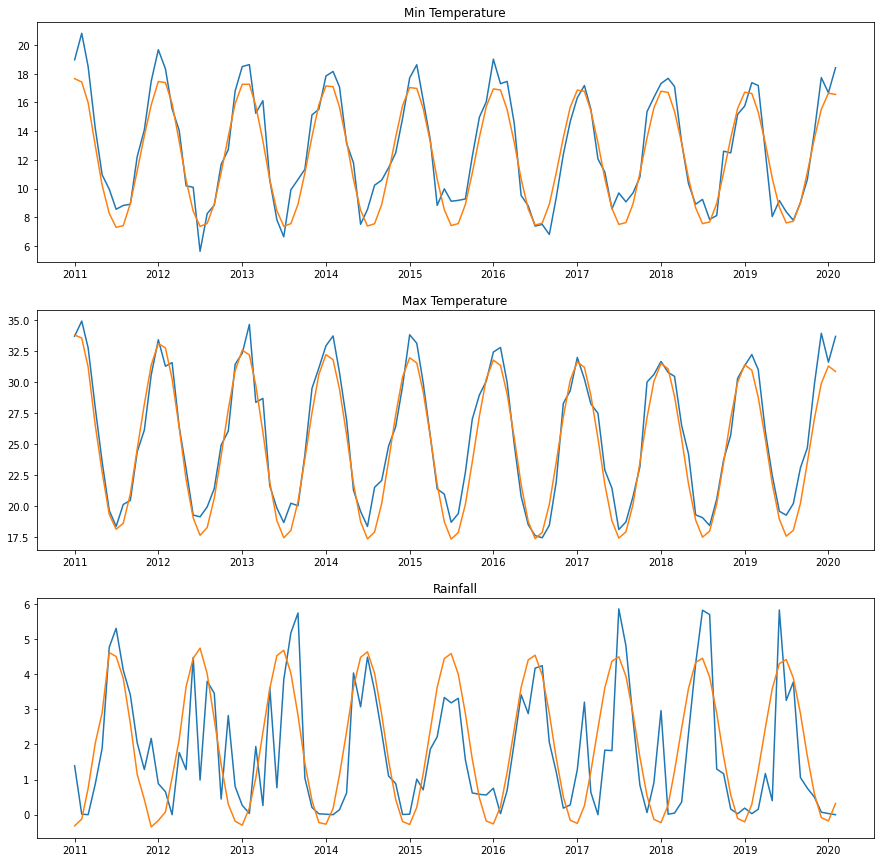

In [36]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
# plt.plot(dfTrain['meantemp'])
plt.plot(perthTemp_Test_MS['mintemp'])
plt.plot(predictionDF['mintemp'])
plt.title('Min Temperature')

plt.subplot(3,1,2)
# plt.plot(dfTrain['humidity'])
plt.plot(perthTemp_Test_MS['maxtemp'])
plt.plot(predictionDF['maxtemp'])
plt.title('Max Temperature')

plt.subplot(3,1,3)
# plt.plot(dfTrain['wind_speed'])
plt.plot(perthTemp_Test_MS['rainfall'])
plt.plot(predictionDF['rainfall'])
plt.title('Rainfall')

plt.show()

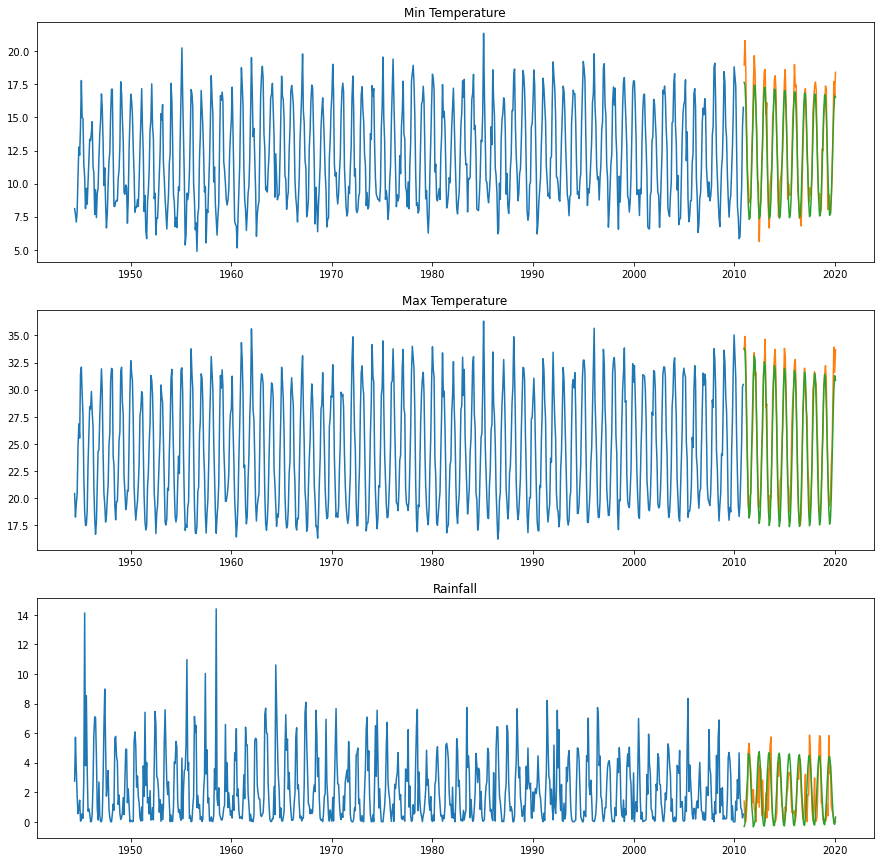

In [37]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(perthTemp_Train_MS['mintemp'])
plt.plot(perthTemp_Test_MS['mintemp'])
plt.plot(predictionDF['mintemp'])
plt.title('Min Temperature')

plt.subplot(3,1,2)
plt.plot(perthTemp_Train_MS['maxtemp'])
plt.plot(perthTemp_Test_MS['maxtemp'])
plt.plot(predictionDF['maxtemp'])
plt.title('Max Temperature')

plt.subplot(3,1,3)
plt.plot(perthTemp_Train_MS['rainfall'])
plt.plot(perthTemp_Test_MS['rainfall'])
plt.plot(predictionDF['rainfall'])
plt.title('Rainfall')

plt.show()

#### 5.4 Evaluate the forecasts

In [38]:
mae = mean_absolute_error(perthTemp_Test_MS['mintemp'], predictionDF['mintemp'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(perthTemp_Test_MS['mintemp'], predictionDF['mintemp'])
print('MAPE: %.3f' % mape)

MAE: 1.034
MAPE: 0.086


In [39]:
mae = mean_absolute_error(perthTemp_Test_MS['maxtemp'], predictionDF['maxtemp'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(perthTemp_Test_MS['maxtemp'], predictionDF['maxtemp'])
print('MAPE: %.3f' % mape)

MAE: 1.165
MAPE: 0.046


In [40]:
mae = mean_absolute_error(perthTemp_Test_MS['rainfall'], predictionDF['rainfall'])
print('MAE: %.3f' % mae)

mape = mean_absolute_percentage_error(perthTemp_Test_MS['rainfall'], predictionDF['rainfall'])
print('MAPE: %.3f' % mape)

MAE: 0.960
MAPE: 194726632757142.688
